# BRONZE LAYER

In [ ]:
# Install required libraries
!pip install cassandra-driver

# Import the necessary libraries
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import json
import pandas as pd

# The secure connect bundle
cloud_config= {
  'secure_connect_bundle': 'secure-connect-finalproject.zip'
}

with open("finalproject-token.json") as f:
    secrets = json.load(f)

CLIENT_ID = secrets["clientId"]
CLIENT_SECRET = secrets["secret"]

auth_provider = PlainTextAuthProvider(CLIENT_ID, CLIENT_SECRET)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

if session:
  print('Connected!')
else:
  print("An error occurred.")

In [ ]:
# Install kagglehub
!pip install kagglehub

import os

# Move kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API Key set up successfully!")


In [ ]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("okhiriadaveoseghale/100000-sales-records")

# Show the path where the dataset is stored
print("Path to dataset files:", path)


In [ ]:
# @title See kaggle File Path and change the name
import os

# List the files in the downloaded path
print("Files in the dataset folder:")
print(os.listdir(path))

#import os

# Current file name (replace with actual name)
#current_file = f"{path}/100000 Sales Records.csv"

# New file name
#new_file = f"{path}/dataset.csv"

# Rename the file
#os.rename(current_file, new_file)

#print("File renamed successfully!")
#print("New file name:", new_file)


In [ ]:
import pandas as pd

# Replace 'file_name.csv' with the correct file name (check the dataset folder)
data_path = f"{path}/100000 Sales Records.csv"
df = pd.read_csv(data_path)

# Display the first 5 rows
print("Sample Data:")
print(df.head().to_string(index=True))

# Check the size of the dataset
print(f"Number of rows: {len(df)}, Number of columns: {len(df.columns)}")

In [ ]:
# Set the keyspace
session.set_keyspace('finalproject')  # Replace 'bronze_layer' with your keyspace name

# Create the table with matching column names and types
create_table_query = """
CREATE TABLE IF NOT EXISTS sales_bronze (
    order_id BIGINT PRIMARY KEY,
    region TEXT,
    country TEXT,
    item_type TEXT,
    sales_channel TEXT,
    order_priority TEXT,
    order_date DATE,
    ship_date DATE,
    units_sold INT,
    unit_price FLOAT,
    unit_cost FLOAT,
    total_revenue FLOAT,
    total_cost FLOAT,
    total_profit FLOAT
);
"""
session.execute(create_table_query)
print("Table 'sales_bronze' created successfully!")


In [ ]:
from datetime import datetime

# Convert dates in DataFrame to YYYY-MM-DD
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%m/%d/%Y')

# Insert data
insert_query = """
INSERT INTO sales_bronze (order_id, region, country, item_type, sales_channel, order_priority,
                          order_date, ship_date, units_sold, unit_price, unit_cost,
                          total_revenue, total_cost, total_profit)
VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
"""

for _, row in df.iterrows():
    session.execute(insert_query, (
        int(row['Order ID']),
        row['Region'],
        row['Country'],
        row['Item Type'],
        row['Sales Channel'],
        row['Order Priority'],
        row['Order Date'].date(),  # Convert to DATE
        row['Ship Date'].date(),  # Convert to DATE
        int(row['Units Sold']),
        float(row['Unit Price']),
        float(row['Unit Cost']),
        float(row['Total Revenue']),
        float(row['Total Cost']),
        float(row['Total Profit'])
    ))

print("Data inserted successfully with DATE fields!")


Data inserted successfully with DATE fields!


In [ ]:
# Count rows in the table
count_query = "SELECT COUNT(*) FROM finalproject.sales_bronze;"
rows = session.execute(count_query)
for row in rows:
    print(f"Number of rows in 'sales_bronze': {row[0]}")

Number of rows in 'sales_bronze': 100000


In [ ]:
import pandas as pd

column_order = ['order_id', 'region', 'country', 'item_type', 'sales_channel',
                'order_priority', 'order_date', 'ship_date', 'units_sold',
                'unit_price', 'unit_cost', 'total_revenue', 'total_cost', 'total_profit']

# Fetch rows from Cassandra table
rows = session.execute("SELECT * FROM finalproject.sales_bronze;")

# Convert rows to a list of dictionaries
data = [row._asdict() for row in rows]

# Create a Pandas DataFrame
df = pd.DataFrame(data, columns=column_order)

# Display the table
print("Table Data:")
print(df.head(10).to_string(index=True))  # Display the first 10 rows


Table Data:
    order_id                             region       country      item_type sales_channel order_priority  order_date   ship_date  units_sold  unit_price   unit_cost  total_revenue    total_cost  total_profit
0  313350093  Central America and the Caribbean       Grenada      Household       Offline              M  2015-04-14  2015-05-18        6111  668.270020  502.540009   4.083798e+06  3.071022e+06  1.012776e+06
1  569098079                             Europe       Ireland     Vegetables       Offline              M  2013-02-08  2013-03-08        7623  154.059998   90.930000   1.174399e+06  6.931594e+05  4.812400e+05
2  909466111  Central America and the Caribbean    Costa Rica         Cereal       Offline              H  2010-12-09  2010-12-27          88  205.699997  117.110001   1.810160e+04  1.030568e+04  7.795920e+03
3  638715350                             Europe       Ireland  Personal Care        Online              H  2015-01-28  2015-03-07        8921   81.73000

# SILVER LAYER

In [13]:
# Duplicate the DataFrame for cleaning
df_clean = df.copy()

print("DataFrame duplicated!")

DataFrame duplicated!


In [14]:
print("Column Names:")
print(df_clean.columns)

Column Names:
Index(['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority',
       'Order Date', 'Order ID', 'Ship Date', 'Units Sold', 'Unit Price',
       'Unit Cost', 'Total Revenue', 'Total Cost', 'Total Profit'],
      dtype='object')


In [ ]:
import pandas as pd

# Display the first 5 rows
print("Sample Data:")
print(df_clean.head().to_string(index=True))

# Check the size of the dataset
print(f"Number of rows: {len(df_clean)}, Number of columns: {len(df_clean.columns)}")

Sample Data:
                              Region                Country      Item Type Sales Channel Order Priority Order Date   Order ID   Ship Date  Units Sold  Unit Price  Unit Cost  Total Revenue  Total Cost  Total Profit
0       Middle East and North Africa             Azerbaijan         Snacks        Online              C  10/8/2014  535113847  10/23/2014         934      152.58      97.44      142509.72    91008.96      51500.76
1  Central America and the Caribbean                 Panama      Cosmetics       Offline              L  2/22/2015  874708545   2/27/2015        4551      437.20     263.33     1989697.20  1198414.83     791282.37
2                 Sub-Saharan Africa  Sao Tome and Principe         Fruits       Offline              M  12/9/2015  854349935   1/18/2016        9986        9.33       6.92       93169.38    69103.12      24066.26
3                 Sub-Saharan Africa  Sao Tome and Principe  Personal Care        Online              M  9/17/2014  892836844  10/1

Checking for duplicate rows

In [ ]:
# Check for duplicate rows
duplicates = df_clean.duplicated(keep=False)  # keep=False marks all duplicates, including the first occurrence

print(f"Number of duplicate rows: {duplicates.sum()}")

# Display duplicate rows in a clean format
if duplicates.sum() > 0:
    print("Duplicate Rows:")
    print(df_clean[duplicates].to_string(index=False))
else:
    print("No duplicate rows found.")


Number of duplicate rows: 0
No duplicate rows found.


Remove duplicate rows

In [ ]:
# Remove duplicate rows
df_clean = df_clean.drop_duplicates()

print("Duplicates removed successfully!")
print(f"Number of rows after removing duplicates: {len(df_clean)}")


Checking for duplicate order ids

In [ ]:
# Check for duplicate Order ID values
duplicate_order_ids = df_clean['Order ID'][df_clean['Order ID'].duplicated(keep=False)]

# Display the result
if len(duplicate_order_ids) > 0:
    print("Duplicate Order IDs Found:")
    print(df_clean[df_clean['Order ID'].duplicated(keep=False)].to_string(index=False))
else:
    print("No duplicate Order IDs found.")


No duplicate Order IDs found.


Keep rows with unique ORDER IDs

In [ ]:
# Drop duplicates and keep only the first occurrence
df_clean = df_clean.drop_duplicates(subset='Order ID', keep='first')

print("Duplicates removed. Cleaned DataFrame:")
print(df_clean)


Checking for missing or null values

In [ ]:
# Check for missing values in each column
print("Missing Values in Each Column:")
print(df_clean.isnull().sum())


Fill missing values with default values

In [ ]:
# Fill missing values for all columns in the DataFrame
df_clean['region'].fillna('Unknown', inplace=True)
df_clean['country'].fillna('Unknown', inplace=True)
df_clean['item_type'].fillna('Miscellaneous', inplace=True)
df_clean['sales_channel'].fillna('Offline', inplace=True)
df_clean['order_priority'].fillna('M', inplace=True)

# Fill date columns with the earliest date or a placeholder
df_clean['order_date'].fillna(pd.Timestamp('2000-01-01'), inplace=True)
df_clean['ship_date'].fillna(pd.Timestamp('2000-01-01'), inplace=True)

# Fill numerical columns with 0 or column mean
df_clean['units_sold'].fillna(0, inplace=True)
df_clean['unit_price'].fillna(df_clean['unit_price'].mean(), inplace=True)
df_clean['unit_cost'].fillna(df_clean['unit_cost'].mean(), inplace=True)
df_clean['total_revenue'].fillna(0, inplace=True)
df_clean['total_cost'].fillna(0, inplace=True)
df_clean['total_profit'].fillna(0, inplace=True)

print("All missing values have been filled.")


Correcting Date Formats

In [ ]:
# Convert 'Order Date' and 'Ship Date' to datetime format
df_clean['Order Date'] = pd.to_datetime(df_clean['Order Date'], format='%m/%d/%Y', errors='coerce')
df_clean['Ship Date'] = pd.to_datetime(df_clean['Ship Date'], format='%m/%d/%Y', errors='coerce')

print("Date columns converted to datetime format.")


Date columns converted to datetime format.


Standardizing numeric columns

In [ ]:
# Convert numeric columns to the correct type
numeric_columns = ['Units Sold', 'Unit Price', 'Unit Cost', 'Total Revenue', 'Total Cost', 'Total Profit']
for col in numeric_columns:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

print("Numeric columns standardized.")


Numeric columns standardized.


Checking for inconsistencies in region and country names

In [ ]:
# Display all unique values in the 'Region' column
print("Distinct Regions:")
print(df_clean['Region'].unique())


Distinct Regions:
['Middle East and North Africa' 'Central America and the Caribbean'
 'Sub-Saharan Africa' 'Europe' 'Asia' 'Australia and Oceania'
 'North America']


In [ ]:
# Display all unique values in the 'Country' column
print("Distinct Countries:")
print(df_clean['Country'].unique())
print("Total Unique Countries:", df_clean['Country'].nunique())

Distinct Countries:
['Azerbaijan' 'Panama' 'Sao Tome and Principe' 'Belize' 'Denmark'
 'Germany' 'Turkey' 'United Kingdom' 'Kazakhstan' 'Haiti' 'Italy' 'Malta'
 'Jordan' 'Cambodia' 'Saint Kitts and Nevis ' 'Cameroon' 'Bahrain'
 'Solomon Islands' 'Monaco' 'Comoros' 'Iceland' 'Zambia' 'Egypt' 'Togo'
 'Saudi Arabia' 'Morocco' 'Tunisia ' 'Angola' 'Vietnam' 'Belarus'
 'Myanmar' 'Lithuania' 'Switzerland' 'Antigua and Barbuda ' 'Mongolia'
 'Greenland' 'Eritrea' 'Saint Vincent and the Grenadines' 'Portugal'
 'Somalia' 'Israel' 'Dominica' 'Luxembourg' 'Singapore' 'Cyprus'
 'Botswana' 'Malawi' 'Kyrgyzstan' 'Macedonia' 'Rwanda' 'Cape Verde'
 'Pakistan' 'Libya' 'Bangladesh' 'Benin' 'Burundi' 'China' 'Albania'
 'Bulgaria' 'Central African Republic' 'Ukraine' 'Uganda' 'Ghana'
 'Namibia' 'Republic of the Congo' 'Netherlands' 'Australia' 'Montenegro'
 'Iraq' "Cote d'Ivoire" 'Mexico' 'Slovakia' 'Afghanistan' 'Indonesia'
 'Thailand' 'Mali' 'Lebanon' 'South Korea' 'United Arab Emirates'
 'Georgia' 'Guine

# GOLD LAYER

## Gold Table 1

In [15]:
# Duplicate the DataFrame for cleaning
df1 = df_clean.copy()

print("DataFrame duplicated!")

DataFrame duplicated!


Group 1 - Total Revenue vs. Total Cost by Country (Using Function)

In [ ]:
def revenue_cost_profit(df, group_by_column='Country', revenue_column='Total Revenue', cost_column='Total Cost'):
    """
    Groups data by a specified column and calculates Total Revenue, Total Cost, and Total Profit.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing revenue and cost columns.
        group_by_column (str): The column to group by (e.g., 'Country').
        revenue_column (str): The column containing revenue values.
        cost_column (str): The column containing cost values.

    Returns:
        pd.DataFrame: A DataFrame with Total Revenue, Total Cost, and Total Profit grouped by the specified column.
    """
    # Group data by the specified column and calculate Total Revenue and Total Cost
    aggregated_data = df.groupby(group_by_column, as_index=False).agg({
        revenue_column: 'sum',
        cost_column: 'sum'
    })

    # Add a column for Total Profit
    aggregated_data['Total Profit'] = aggregated_data[revenue_column] - aggregated_data[cost_column]

    # Display the Gold Table
    print(f"Gold Table: {revenue_column} vs. {cost_column} by {group_by_column}")
    return aggregated_data

# Output
print(revenue_cost_profit(df1))


In [ ]:
# Call the function and store the result
gold_table = revenue_cost_profit(df_clean)

# Export to CSV
gold_table.to_csv('revenue_cost_profit_table.csv', index=False)
print("Gold table saved as 'revenue_cost_profit_table.csv'.")


Gold Table: Total Revenue vs. Total Cost by Country
Gold table saved as 'revenue_cost_profit_table.csv'.


In [ ]:
from google.colab import files

# Download CSV file
files.download('revenue_cost_profit_table.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Gold Table 2

In [17]:
# Duplicate the DataFrame for cleaning
df2 = df_clean.copy()

print("DataFrame duplicated!")

DataFrame duplicated!


Group 2 - Product performance by channel (Using Function)

In [36]:
def product_performance_by_channel(df, group_by_column='Sales Channel', product_column='Item Type',
                                   units_column='Units Sold'):
    """
    Groups data by sales channel and product, calculates Total Units Sold for each combination,
    and determines which products are sold more in each channel.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing sales data.
        group_by_column (str): The column to group by (default is 'sales_channel').
        product_column (str): The column containing product names.
        units_column (str): The column containing units sold.

    Returns:
        pd.DataFrame: A DataFrame showing Total Units Sold for each product by sales channel.
    """
    # Group data by sales channel and product
    aggregated_data = df.groupby([group_by_column, product_column], as_index=False).agg({
        units_column: 'sum'
    })

    # Pivot the table to make it easier to compare sales across channels
    comparison_table = aggregated_data.pivot(index=product_column, columns=group_by_column, values=units_column)

    # Add a column to indicate where each product is sold more (Offline or Online)
    comparison_table['Preferred Channel'] = comparison_table.idxmax(axis=1)

    # Fill NaN values with 0 for better handling of missing data
    comparison_table = comparison_table.fillna(0)

    # Display the Gold Table
    print(f"Product Performance by {group_by_column}")
    return comparison_table

# Example Usage
# Assuming 'df_clean' is your DataFrame
data = product_performance_by_channel(df2)
print(data)


Product Performance by Sales Channel
Sales Channel     Offline    Online Preferred Channel
Item Type                                            
Baby Food        21088200  20823420           Offline
Beverages        20658450  20855763            Online
Cereal           20983531  21270887            Online
Clothes          21139857  20633583           Offline
Cosmetics        21075752  20848712           Offline
Fruits           20371892  20425384            Online
Household        20475149  20983646            Online
Meat             21015813  20729554           Offline
Office Supplies  21195288  21098042           Offline
Personal Care    20686954  20830812            Online
Snacks           20962254  20736838           Offline
Vegetables       20218032  21036804            Online


In [ ]:
# Call the function and store the result
gold_table = product_performance_by_channel(df_clean)

# Export to CSV
gold_table.to_csv('product_performance_by_channel.csv', index=False)
print("Gold table saved as 'product_performance_by_channel.csv'.")


Product Performance by Sales Channel
Gold table saved as 'product_performance_by_channel.csv'.


In [ ]:
from google.colab import files

# Download CSV file
files.download('product_performance_by_channel.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Gold Table 3

In [19]:
# Duplicate the DataFrame for cleaning
df3 = df_clean.copy()

print("DataFrame duplicated!")

DataFrame duplicated!


Group 3 - Most Popular Item By Country (Using Function)

In [47]:
def most_popular_item_by_country(df, country_column='Country', item_column='Item Type', units_column='Units Sold'):
    """
    Groups data by Country and Item Type to find the most popular Item Type for each country based on Units Sold.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing country, item type, and units sold columns.
        country_column (str): Column name for countries.
        item_column (str): Column name for item types.
        units_column (str): Column name for units sold.

    Returns:
        pd.DataFrame: A DataFrame with the most popular item type and total units sold for each country.
    """
    # Group data by Country and Item Type, and sum Units Sold
    grouped_data = df.groupby([country_column, item_column], as_index=False)[units_column].sum()

    # Find the most popular Item Type for each country
    most_popular = grouped_data.loc[grouped_data.groupby(country_column)[units_column].idxmax()]

    # Rename columns for clarity
    most_popular.columns = [country_column, 'Most Popular Item Type', 'Total Units Sold']

    # Display the Gold Table
    print("Gold Table: Most Popular Item Type by Country")
    return most_popular

# Output
data = most_popular_item_by_country(df3)
print(data)


Gold Table: Most Popular Item Type by Country
           Country Most Popular Item Type  Total Units Sold
7      Afghanistan                   Meat            273402
23         Albania             Vegetables            276459
32         Algeria        Office Supplies            252459
39         Andorra                Clothes            271020
51          Angola                Clothes            232193
...            ...                    ...               ...
2163  Vatican City                Clothes            306889
2175       Vietnam                Clothes            241258
2185         Yemen              Beverages            336903
2203        Zambia                   Meat            275974
2208      Zimbabwe              Baby Food            256453

[185 rows x 3 columns]


In [ ]:
# Call the function and store the result
most_popular_items = most_popular_item_by_country(df_clean)

# Export to CSV
most_popular_items.to_csv('most_popular_items.csv', index=False)
print("Gold table saved as 'most_popular_items.csv'.")


Gold Table: Most Popular Item Type by Country
Gold table saved as 'most_popular_items.csv'.


In [ ]:
from google.colab import files

# Download CSV file
files.download('most_popular_items.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# VISUALIZATION

## Gold Table 1

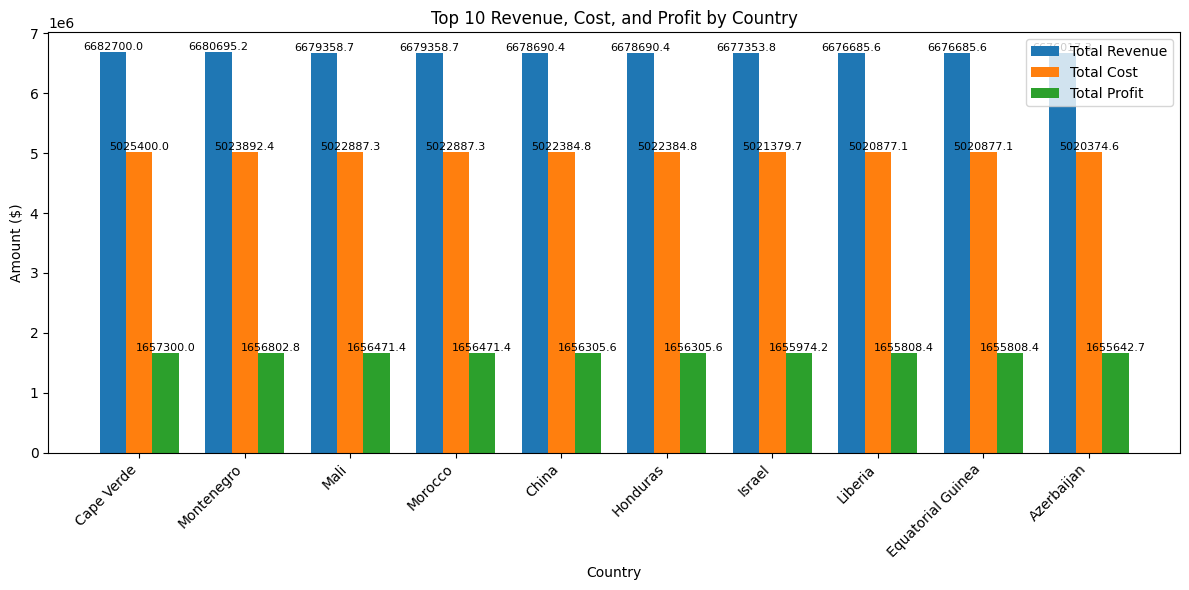

In [28]:
import matplotlib.pyplot as plt
import pandas as pd


# Generate the Gold Table
gold_table = df1.copy()
gold_table['Total Profit'] = gold_table['Total Revenue'] - gold_table['Total Cost']
gold_table = gold_table.sort_values('Total Revenue', ascending=False).head(10)

# Plot the data
plt.figure(figsize=(12, 6))  # Increased size for clarity
x = gold_table['Country']
revenue = gold_table['Total Revenue']
cost = gold_table['Total Cost']
profit = gold_table['Total Profit']

# Define bar positions
bar_width = 0.25
positions = range(len(x))

# Plot each bar group
plt.bar(positions, revenue, width=bar_width, label='Total Revenue')
plt.bar([p + bar_width for p in positions], cost, width=bar_width, label='Total Cost')
plt.bar([p + 2 * bar_width for p in positions], profit, width=bar_width, label='Total Profit')

# Add labels and title
plt.xlabel('Country')
plt.ylabel('Amount ($)')
plt.title('Top 10 Revenue, Cost, and Profit by Country')
plt.xticks([p + bar_width for p in positions], x, rotation=45, ha='right')
plt.legend()

# Add value annotations above bars (optional for clarity)
for i, value in enumerate(revenue):
    plt.text(i, value, f'{value:.1f}', ha='center', va='bottom', fontsize=8)
for i, value in enumerate(cost):
    plt.text(i + bar_width, value, f'{value:.1f}', ha='center', va='bottom', fontsize=8)
for i, value in enumerate(profit):
    plt.text(i + 2 * bar_width, value, f'{value:.1f}', ha='center', va='bottom', fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()


## Gold Table 2

In [41]:
print("Column Names:")
print(data.columns)

Column Names:
Index(['Offline', 'Online', 'Preferred Channel'], dtype='object', name='Sales Channel')


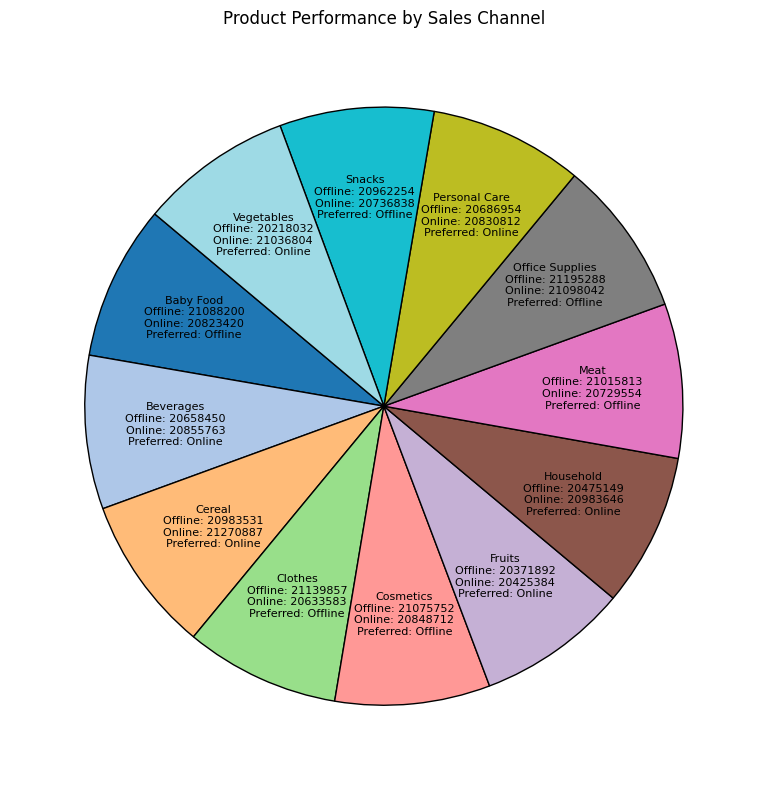

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for the pie chart
sizes = data['Offline'] + data['Online']  # Total sales for each product type
labels = data.index  # Item types
colors = cm.tab20(np.linspace(0, 1, len(sizes)))  # Unique colors

# Plot the pie chart
fig, ax = plt.subplots(figsize=(12, 8))
wedges, texts = ax.pie(
    sizes,
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)

# Add labels inside the slices
for i, wedge in enumerate(wedges):
    # Compute the position of the text
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = np.cos(np.radians(angle)) * 0.7  # Adjust 0.7 for label placement radius
    y = np.sin(np.radians(angle)) * 0.7

    # Label text including Item Type, Offline/Online sales, and Preferred Channel
    label = (
        f"{labels[i]}\n"
        f"Offline: {data.iloc[i]['Offline']}\n"
        f"Online: {data.iloc[i]['Online']}\n"
        f"Preferred: {data.iloc[i]['Preferred Channel']}"
    )

    # Place the text inside the slice
    ax.text(x, y, label, ha='center', va='center', fontsize=8)

# Title and layout
plt.title("Product Performance by Sales Channel")
plt.tight_layout()
plt.show()


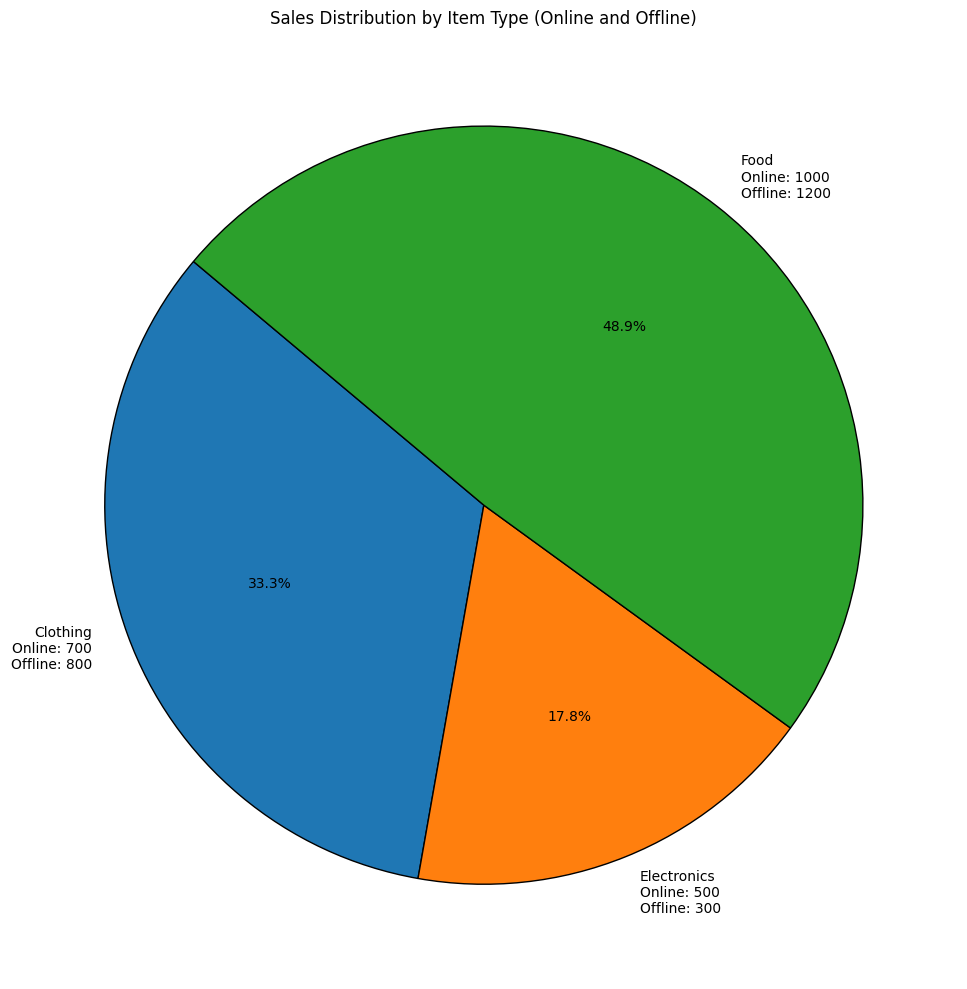

In [34]:
import pandas as pd
import matplotlib.pyplot as plt


# Group data by Sales Channel and Item Type
aggregated_data = df.groupby(['Sales Channel', 'Item Type'], as_index=False).agg({'Units Sold': 'sum'})

# Pivot the data to compare sales channels
comparison_table = aggregated_data.pivot(index='Item Type', columns='Sales Channel', values='Units Sold')

# Fill NaN values with 0 for better handling of missing data
comparison_table = comparison_table.fillna(0)

# Calculate total sales per item
comparison_table['Total Sales'] = comparison_table.sum(axis=1)

# Prepare data for the pie chart
labels = []
sizes = []
for item_type in comparison_table.index:
    online = comparison_table.loc[item_type, 'Online']
    offline = comparison_table.loc[item_type, 'Offline']
    total = online + offline

    # Append label with details of Online and Offline sales
    labels.append(f"{item_type}\nOnline: {online}\nOffline: {offline}")
    sizes.append(total)

# Plot the pie chart
plt.figure(figsize=(10, 10))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)

# Add a title
plt.title('Sales Distribution by Item Type (Online and Offline)')
plt.tight_layout()
plt.show()


## Gold Table 3

In [50]:
print(data.columns)

Index(['Country', 'Most Popular Item Type', 'Total Units Sold'], dtype='object')


In [59]:
import pandas as pd
import plotly.express as px


df = pd.DataFrame(data)

# Create a Sunburst chart
fig = px.sunburst(
    df,
    path=['Most Popular Item Type', 'Country'],  # Hierarchy: Item Type > Country
    values='Total Units Sold',  # Size by Total Units Sold
    title='Sunburst Chart: Most Popular Item Type by Country',
    color='Total Units Sold',  # Optional: Color by Total Units Sold
    hover_data={'Country': True, 'Total Units Sold': True, 'Most Popular Item Type': True}

)

fig.update_traces(
    hovertemplate="<b>Country:</b> %{label}<br>" +
                  "<b>Total Units Sold:</b> %{value}<br>" +
                  "<b>Item Type:</b> %{id.split('/')[0]}"
)

# Show the chart
fig.show()


# EXTRA

Group 4 - Monthly, Quarterly, Yearly Profit (Using Function)

In [ ]:
import pandas as pd

def profit_table(df, date_column='Order Date', profit_column='Total Profit'):
    """
    Creates a combined table with monthly, quarterly, and yearly aggregated profits.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing the order date and profit columns.
        date_column (str): Name of the column containing order dates.
        profit_column (str): Name of the column containing profit values.

    Returns:
        pd.DataFrame: Aggregated profit table with Year, Quarter, Month, and Total Profit.
    """
    # Ensure 'Order Date' is in datetime format
    df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%Y', errors='coerce')

    # Aggregate total profit
    aggregated_profit = df.groupby([date_column]).agg({
        profit_column: 'sum'
    }).reset_index()

    # Add Month, Quarter, and Year columns
    aggregated_profit['Month'] = aggregated_profit[date_column].dt.to_period('M').astype(str)
    aggregated_profit['Quarter'] = aggregated_profit[date_column].dt.to_period('Q').astype(str)
    aggregated_profit['Year'] = aggregated_profit[date_column].dt.year

    # Final aggregated table
    final_profit_table = aggregated_profit.groupby(['Year', 'Quarter', 'Month'])[profit_column].sum().reset_index()

    print("Combined Profit Table (Monthly, Quarterly, Yearly):")
    return final_profit_table

#Output
print(profit_table(df_clean))


In [ ]:
# Call the function and store the result
final_profit_table = profit_table(df_clean)

# Export to CSV
final_profit_table.to_csv('final_profit_table.csv', index=False)
print("Profit table saved as 'final_profit_table.csv'.")

Combined Profit Table (Monthly, Quarterly, Yearly):
Profit table saved as 'final_profit_table.csv'.


In [ ]:
from google.colab import files

# Download CSV file
files.download('final_profit_table.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Group 4 - Monthly, Quarterly, Yearly Profit

In [ ]:
# Ensure 'Order Date' is in datetime format
df_clean['Order Date'] = pd.to_datetime(df_clean['Order Date'], format='%m/%d/%Y', errors='coerce')

# Create a combined table with monthly, quarterly, and yearly profits
aggregated_profit = df_clean.groupby(['Order Date']).agg({
    'Total Profit': 'sum'
}).reset_index()

# Add Month, Quarter, and Year columns to the table
aggregated_profit['Month'] = aggregated_profit['Order Date'].dt.to_period('M').astype(str)
aggregated_profit['Quarter'] = aggregated_profit['Order Date'].dt.to_period('Q').astype(str)
aggregated_profit['Year'] = aggregated_profit['Order Date'].dt.year

# Final aggregated table
final_profit_table = aggregated_profit.groupby(['Year', 'Quarter', 'Month'])['Total Profit'].sum().reset_index()

print("Combined Profit Table (Monthly, Quarterly, Yearly):")
print(final_profit_table)


Group 5 - Sales Channel Performance (Using Function)

In [ ]:
def sales_channel_performance(df1, group_by_column='Sales Channel',
                              revenue_column='Total Revenue',
                              cost_column='Total Cost',
                              units_column='Units Sold'):
    """
    Groups data by sales channel and calculates Total Revenue, Total Cost, Total Profit, and Total Units Sold.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing sales data.
        group_by_column (str): The column to group by (default is 'sales_channel').
        revenue_column (str): The column containing revenue values.
        cost_column (str): The column containing cost values.
        units_column (str): The column containing units sold.

    Returns:
        pd.DataFrame: A DataFrame with Total Revenue, Total Cost, Total Profit, and Total Units Sold
                      grouped by the specified column.
    """
    # Group data by the specified column and calculate Total Revenue, Total Cost, and Total Units Sold
    aggregated_data = df1.groupby(group_by_column, as_index=False).agg({
        revenue_column: 'sum',
        cost_column: 'sum',
        units_column: 'sum'
    })

    # Add a column for Total Profit
    aggregated_data['Total Profit'] = aggregated_data[revenue_column] - aggregated_data[cost_column]

    # Add a column for Average Order Value (optional)
    aggregated_data['Average Order Value'] = aggregated_data[revenue_column] / aggregated_data[units_column]

    # Display the Gold Table
    print(f"Gold Table: Performance Metrics by {group_by_column}")
    return aggregated_data

# Example Usage
# Assuming 'df_clean' is your DataFrame
gold_table = sales_channel_performance(df_clean)
print(gold_table)


Group 1 - Total Revenue vs. Total Cost by Country

In [ ]:
# Group data by Country and calculate Total Revenue and Total Cost
revenue_cost_by_country = df_clean.groupby('Country', as_index=False).agg({
    'Total Revenue': 'sum',
    'Total Cost': 'sum'
})

# Add a column for Total Profit (optional)
revenue_cost_by_country['Total Profit'] = revenue_cost_by_country['Total Revenue'] - revenue_cost_by_country['Total Cost']

# Display the Gold Table
print("Gold Table: Total Revenue vs. Total Cost by Country")
print(revenue_cost_by_country)


Group 3 - Most Popular Item By Country

In [ ]:
# Group data by Country and Item Type, and sum Units Sold
item_type_by_country = df_clean.groupby(['Country', 'Item Type'], as_index=False)['Units Sold'].sum()

# Find the most popular Item Type for each country
most_popular_items = item_type_by_country.loc[item_type_by_country.groupby('Country')['Units Sold'].idxmax()]

# Rename columns for clarity
most_popular_items.columns = ['Country', 'Most Popular Item Type', 'Total Units Sold']

# Display the Gold Table
print("Gold Table: Most Popular Item Type by Country")
print(most_popular_items)
